##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Routing with t|ket>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/routing_with_tket"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/routing_with_tket.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/routing_with_tket.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/routing_with_tket.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

Wrap tket's compilation unit framework to keep track of qubit mappings and work with generic devices.

## Setup

Install the ReCirq package:

In [2]:
try:
    import recirq
except ImportError:
    !pip install -q git+https://github.com/quantumlib/ReCirq sympy~=1.6

Now import Cirq, ReCirq and the module dependencies:

In [3]:
import cirq
import recirq
import networkx as nx
from cirq.contrib.svg import SVGCircuit
import numpy as np

In [4]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs
from pytket.placement import GraphPlacement

### Example circuit
We'll route a 3-regular circuit to Sycamore23. To try to clear up some of the confusion about which indices are which, we'll construct the initial circuit with `LineQubits` 10 through 19 which should be thought of as "logical indices".

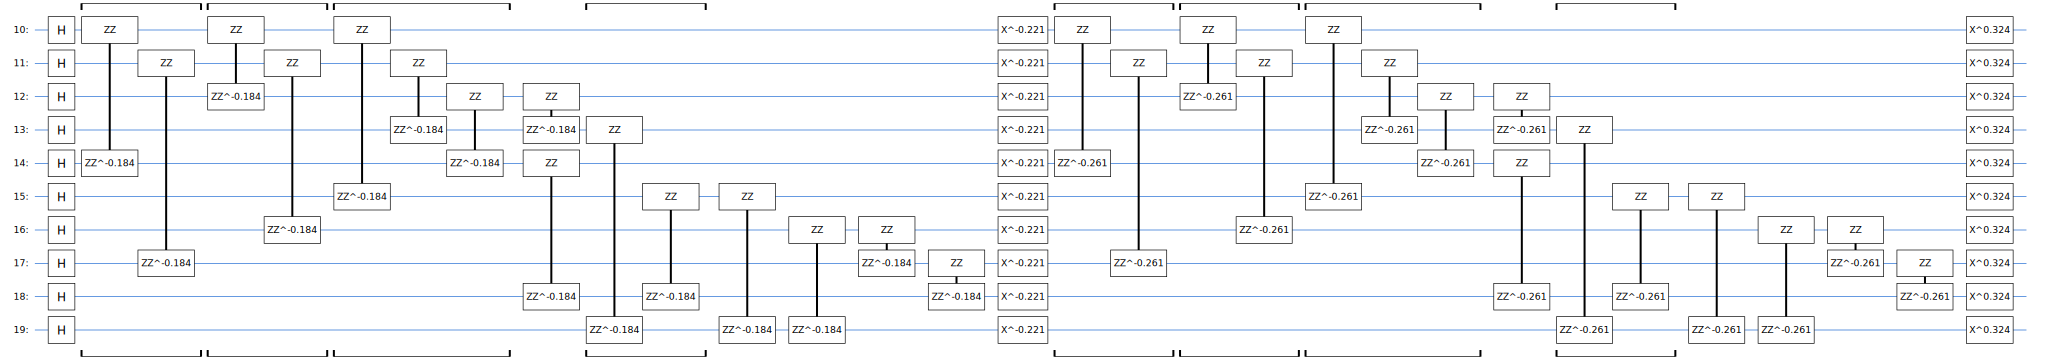

In [5]:
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit
from recirq.qaoa.gates_and_compilation import compile_problem_unitary_to_arbitrary_zz, \
    compile_driver_unitary_to_rx

problem_graph = nx.random_regular_graph(d=3, n=10)
nx.set_edge_attributes(problem_graph, values=1, name='weight')
circuit_qubits = cirq.LineQubit.range(10, 20)
gammas = np.random.randn(2)
betas = np.random.randn(2)
circuit = get_generic_qaoa_circuit(
    problem_graph=problem_graph,
    qubits=circuit_qubits,
    gammas=gammas,
    betas=betas)
circuit = compile_problem_unitary_to_arbitrary_zz(circuit)
circuit = compile_driver_unitary_to_rx(circuit)
SVGCircuit(circuit)

### "Route" this circuit

Let's look at the "connectivity graph" of the circuit vs. that of the device

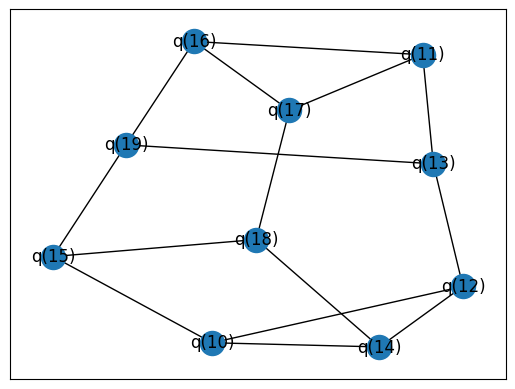

In [6]:
import cirq.contrib.routing as ccr

uncompiled_c_graph = ccr.get_circuit_connectivity(circuit)
nx.draw_networkx(uncompiled_c_graph)

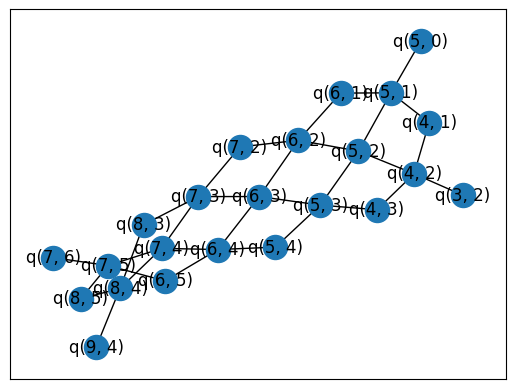

In [7]:
import cirq_google as cg

dev_graph = ccr.gridqubits_to_graph_device(cg.Sycamore23.metadata.qubit_set)
nx.draw_networkx(dev_graph)

In [8]:
# alias for the device. If this notebook were wrapped
# in a function, `circuit` and `device` would be the arguments
device = cg.Sycamore23

### Convert to pytket `Device`
The provided function doesn't work with `GridDevice`. We use existing functionality to turn Devices into graphs to provide a more robust solution.

In [9]:
import pytket
from recirq.qaoa.placement import _device_to_tket_device

tk_circuit = pytket.extensions.cirq.cirq_to_tk(circuit)
tk_device = _device_to_tket_device(device)

In [10]:
tk_circuit.qubits

[q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19]]

In [11]:
tk_device.coupling

[(grid[7, 3], grid[6, 3]),
 (grid[7, 3], grid[7, 4]),
 (grid[7, 3], grid[7, 2]),
 (grid[7, 3], grid[8, 3]),
 (grid[6, 3], grid[6, 2]),
 (grid[6, 3], grid[6, 4]),
 (grid[6, 3], grid[5, 3]),
 (grid[7, 4], grid[6, 4]),
 (grid[7, 4], grid[7, 5]),
 (grid[7, 4], grid[8, 4]),
 (grid[7, 2], grid[6, 2]),
 (grid[8, 3], grid[8, 4]),
 (grid[5, 4], grid[6, 4]),
 (grid[5, 4], grid[5, 3]),
 (grid[6, 4], grid[6, 5]),
 (grid[5, 3], grid[4, 3]),
 (grid[5, 3], grid[5, 2]),
 (grid[6, 1], grid[6, 2]),
 (grid[6, 1], grid[5, 1]),
 (grid[6, 2], grid[5, 2]),
 (grid[5, 1], grid[4, 1]),
 (grid[5, 1], grid[5, 2]),
 (grid[5, 1], grid[5, 0]),
 (grid[5, 2], grid[4, 2]),
 (grid[6, 5], grid[7, 5]),
 (grid[7, 5], grid[7, 6]),
 (grid[7, 5], grid[8, 5]),
 (grid[8, 4], grid[9, 4]),
 (grid[8, 4], grid[8, 5]),
 (grid[4, 1], grid[4, 2]),
 (grid[4, 2], grid[4, 3]),
 (grid[4, 2], grid[3, 2])]

### Placement and routing pass

In [12]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs, PlacementPass
from pytket.placement import GraphPlacement

In [13]:
unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
passes = SequencePass([
    PlacementPass(GraphPlacement(tk_device)),
    RoutingPass(tk_device)])
passes.apply(unit)
valid = unit.check_all_predicates()
assert valid

### The initial mapping
This maps from logical LineQubits to "physical" GridQubits

In [14]:
unit.initial_map

{q[10]: grid[6, 4],
 q[11]: grid[6, 2],
 q[12]: grid[7, 4],
 q[13]: grid[7, 3],
 q[14]: grid[5, 4],
 q[15]: grid[6, 3],
 q[16]: grid[7, 2],
 q[17]: grid[5, 2],
 q[18]: grid[5, 3],
 q[19]: grid[8, 3]}

### Bookkept initial mapping
We "decode" our tket conventions back into Cirq idioms.

In [15]:
def tk_to_cirq_qubit(tk):
    ind = tk.index
    return cirq.LineQubit(ind[0]) if len(ind) == 1 else cirq.GridQubit(*ind)

initial_map = {tk_to_cirq_qubit(n1): tk_to_cirq_qubit(n2) for n1, n2 in unit.initial_map.items()}
initial_map

{cirq.LineQubit(10): cirq.GridQubit(6, 4),
 cirq.LineQubit(11): cirq.GridQubit(6, 2),
 cirq.LineQubit(12): cirq.GridQubit(7, 4),
 cirq.LineQubit(13): cirq.GridQubit(7, 3),
 cirq.LineQubit(14): cirq.GridQubit(5, 4),
 cirq.LineQubit(15): cirq.GridQubit(6, 3),
 cirq.LineQubit(16): cirq.GridQubit(7, 2),
 cirq.LineQubit(17): cirq.GridQubit(5, 2),
 cirq.LineQubit(18): cirq.GridQubit(5, 3),
 cirq.LineQubit(19): cirq.GridQubit(8, 3)}

### The final mapping
This maps from logical LineQubits to final GridQubits

In [16]:
unit.final_map

{q[10]: grid[7, 4],
 q[11]: grid[7, 2],
 q[12]: grid[6, 4],
 q[13]: grid[6, 3],
 q[14]: grid[5, 4],
 q[15]: grid[8, 3],
 q[16]: grid[6, 2],
 q[17]: grid[5, 2],
 q[18]: grid[5, 3],
 q[19]: grid[7, 3]}

In [17]:
final_map = {tk_to_cirq_qubit(n1): tk_to_cirq_qubit(n2)
             for n1, n2 in unit.final_map.items()}
final_map

{cirq.LineQubit(10): cirq.GridQubit(7, 4),
 cirq.LineQubit(11): cirq.GridQubit(7, 2),
 cirq.LineQubit(12): cirq.GridQubit(6, 4),
 cirq.LineQubit(13): cirq.GridQubit(6, 3),
 cirq.LineQubit(14): cirq.GridQubit(5, 4),
 cirq.LineQubit(15): cirq.GridQubit(8, 3),
 cirq.LineQubit(16): cirq.GridQubit(6, 2),
 cirq.LineQubit(17): cirq.GridQubit(5, 2),
 cirq.LineQubit(18): cirq.GridQubit(5, 3),
 cirq.LineQubit(19): cirq.GridQubit(7, 3)}

### The compilation unit applies the mapping
So our circuit qubits are now GridQubits

In [18]:
unit.circuit.qubits

[grid[5, 2],
 grid[5, 3],
 grid[5, 4],
 grid[6, 2],
 grid[6, 3],
 grid[6, 4],
 grid[7, 2],
 grid[7, 3],
 grid[7, 4],
 grid[8, 3]]

### Convert the circuit back to Cirq

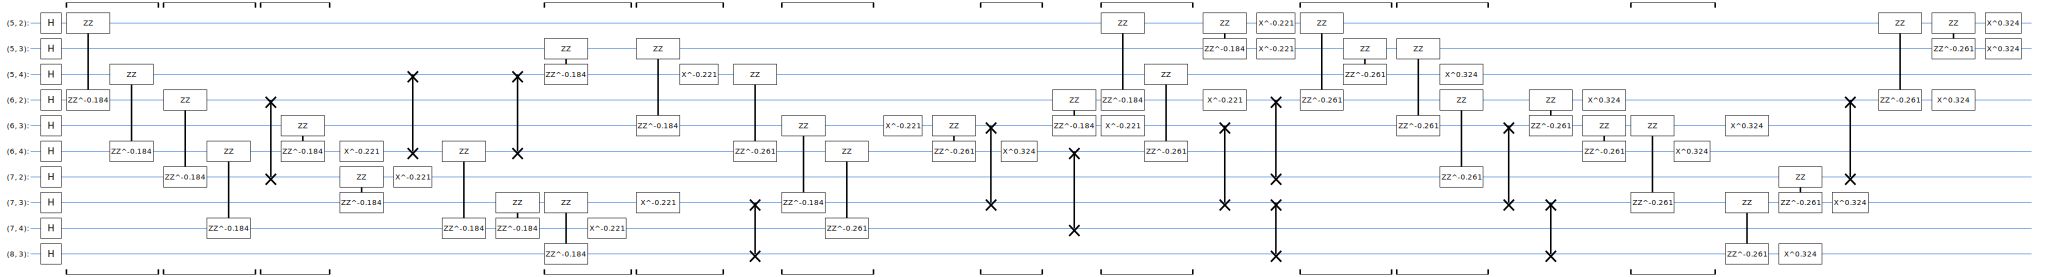

In [19]:
routed_circuit = pytket.extensions.cirq.tk_to_cirq(unit.circuit)
SVGCircuit(routed_circuit)

### Now it's nice and compiled

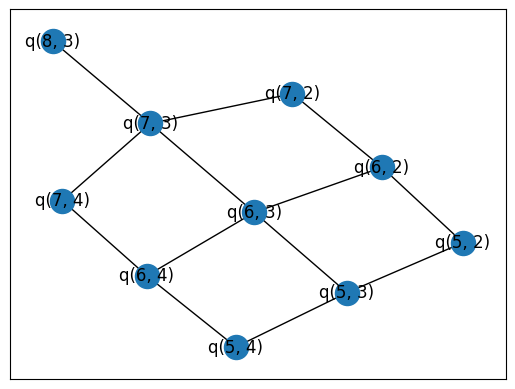

In [20]:
routed_c_graph = ccr.get_circuit_connectivity(routed_circuit)
nx.draw_networkx(routed_c_graph)

### Check that circuits are equivalent

In [21]:
for op in routed_circuit.all_operations():
    if len(op.qubits) != 2:
        continue
    a, b = op.qubits
    assert a.is_adjacent(b)

In [22]:
import cirq.contrib.acquaintance as cca
def permute_gate(qubits, permutation):
    return cca.LinearPermutationGate(
        num_qubits=len(qubits),
        permutation={i: permutation[i] for i in range(len(permutation))}
    ).on(*qubits)

final_to_initial_map = {final_map[cq]: initial_map[cq]
                              for cq in circuit_qubits}
initial_qubits = [initial_map[cq] for cq in circuit_qubits]
final_permutation = [initial_qubits.index(final_to_initial_map[q])
                     for q in initial_qubits]
rcircuit_with_perm = routed_circuit.copy()
rcircuit_with_perm.append(permute_gate(initial_qubits, final_permutation))
expected = circuit.unitary(qubit_order=cirq.QubitOrder.explicit(circuit_qubits))
actual = rcircuit_with_perm.unitary(qubit_order=cirq.QubitOrder.explicit(initial_qubits))
cirq.testing.assert_allclose_up_to_global_phase(expected, actual, atol=1e-8)